# 2. Computing fluid phase equilibria with the FE-ANN EoS

This notebook exemplifies how to use the FE-ANN EoS to the critical point and phase equilibria.

The FE-ANN EoS model systems interacting throgh the Mie Potential:

$$ U^{Mie} = \mathcal{C}_{Mie} \epsilon \left[ \left(\frac{\sigma}{r}\right)^{\lambda_r} -  \left(\frac{\sigma}{r}\right)^{\lambda_a} \right], \quad \mathcal{C}_{Mie} = \frac{\lambda_r}{\lambda_r- \lambda_a} \left( \frac{\lambda_r}{\lambda_a}\right)^{\frac{\lambda_a}{\lambda_r - \lambda_a}} $$ 

Here, $\epsilon$ represents the potential well depth, $\sigma$ is the effective monomer diameter, $r$ is the centre-to-centre distance between two Mie monomers, and $\lambda_r$ and $\lambda_a$ are the repulsive and attractive exponent, respectively. The FE-ANN EoS uses dimensionless Lennard-Jones units (equivalently to setting $\epsilon$, $\sigma$, the Boltzmann constant $k_b$ and the monomer mass $m$ to 1).

The FE-ANN EoS describes the residual Helmholtz free energy as follows.

$$ A^{res} = ANN(\alpha_{vdw}, \rho, 1/T) - ANN(\alpha_{vdw}, \rho=0.0, 1/T) $$

Where, $A^{res}$ is the dimensionless residual Helmholtz free energy, $\rho$ is the dimensionless density, $T$ is the dimensionless temperature and $\alpha_{vdw}$ is defined a the Mie fluid as follows:

$$ \alpha_{vdw} = \mathcal{C}_{Mie} \left[ \left(\frac{1}{\lambda_a-3} \right) - \left(\frac{1}{\lambda_r-3} \right) \right]$$

**Note: all expressions and quantities in this notebook assume dimensionless units ( $\epsilon = \sigma = k_b = m = 1.$)**

To start using the FE-ANN EoS, firstly, we import the required packages.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root
import tensorflow as tf
# HelmholtzModel_Tinv is the custom TensorFlow model class, only needed if creating a new model from scratch
from helmholtz_model_Tinv import HelmholtzModel_Tinv

# Setting up tensorflow for float64
PRECISSION = 'float64'
type_np = np.float64
type_tf = tf.float64
tf.keras.backend.set_floatx(PRECISSION)

The pre-saved model is loaded using the `tf.keras.models.load_model` function.

In [2]:
# Loading saved model using tensorflow
model_path = '../fe-ann-eos'
model = tf.keras.models.load_model(model_path, compile=False)

The EoS is ready to be used. This notebook will exemplify calculations for the Lennard-Jones fluid ($\lambda_r=12$ and $\lambda_a=6$). First, the $\alpha_{vdw}$ parameter is computed.

In [3]:
# Computing α for the Lennard-Jones fluid
lr = 12.
la = 6.
c_alpha = (lr / (lr-la)) * (lr/la)**(la/(lr-la))
alpha_aux = c_alpha*(1./(la-3) - 1./(lr-3))

### Critical point calculation

The critical point is computed by solving the following system of equations.

$$ \left( \frac{\partial P}{\partial V} \right)_{T}  = -\rho^2 \left( \frac{\partial P}{\partial \rho} \right)_{T} = 0 $$

$$ \left( \frac{\partial^2 P}{\partial V^2} \right)_{T} = 2\rho^3 \left( \frac{\partial P}{\partial \rho} \right)_{T} + \rho^4 \left( \frac{\partial^2 P}{\partial \rho^2} \right)_{T} = 0$$ 

These two equations are included in the `fobj_crit` function, which can be solved using the `root` function from the `scipy.optimize` package.

In [4]:
# Objetive function to compute critical point.
def fobj_crit(inc, alpha, model):
    alpha = np.array(alpha, ndmin=1)
    rhoad, Tad = np.split(np.asarray(inc), 2)
    d2press = model.d2pressure_drho2(alpha, rhoad, Tad)
    
    press_res, dpress_res, d2press_res = d2press
    
    press_res = press_res.numpy().flatten()
    dpress_res = dpress_res.numpy().flatten()
    d2press_res = d2press_res.numpy().flatten()
    
    press_ideal = rhoad * Tad
    dpress_ideal = 1. * Tad
    d2press_ideal = 0.0

    press = press_res + press_ideal
    dpress = dpress_res + dpress_ideal
    d2press = d2press_res + d2press_ideal
    
    fo = np.hstack([dpress, 2*dpress/rhoad + d2press])
    return fo

# initial guess
Tc0 = 1.3
rhoc0 = 0.3
# solving fobj_crit
sol_crit = root(fobj_crit, x0=[rhoc0, Tc0], args=(alpha_aux, model))
rhoc_model, Tc_model = sol_crit.x

# computing critical pressure
Pc_model = model.pressure([alpha_aux], [rhoc_model], [Tc_model]).numpy()[0] + rhoc_model * Tc_model

print("Computed Critical Point")
print("Critical Density: ", np.round(rhoc_model, 4))
print("Critical Temperature: ", np.round(Tc_model, 4))
print("Critical Pressure: ", np.round(Pc_model, 4))

Computed Critical Point
Critical Density:  0.304
Critical Temperature:  1.3303
Critical Pressure:  0.1392


2023-02-08 14:19:04.089908: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


### Phase envelope calculation

Phase equilibrium is checked by a thermal (temperature), mechanical (pressure) and chemical (chemical potential) equilibrium between a liquid and a vapour phase, as shown below.

$$ T^{liq} = T^{vap}$$
$$ P^{liq} = P^{vap}$$
$$ \mu^{liq} = \mu^{vap}$$

The `fobj_vle` is solved at a given temperature to check that the pressure and chemical potential of the phases are equal.

In [5]:
# Objetive function to compute VLE.
# This function compute the difference between the pressure and chemical potential each phase.
def fobj_vle(rhoad, alpha, Tad, model):
    press_ideal = rhoad * Tad
    press_res = model.pressure(alpha, rhoad, Tad).numpy().flatten()
    press = press_res + press_ideal

    aideal = Tad*(np.log(rhoad) - 1.)
    # daideal_drho = Tad/rhoad
    # chempot_ideal = aideal + rhoad*daideal_drho
    chempot_ideal = aideal + Tad
    chempot_res = model.chemical_potential(alpha, rhoad, Tad).numpy().flatten()
    chempot = chempot_res + chempot_ideal
    fo = np.hstack([np.diff(press), np.diff(chempot)])   
    return fo

# number of points to compute the phase envelope
n = 200
rhol = np.zeros(n) # array to store liquid density
rhov = np.zeros(n) # array to store vapour density
T = np.linspace(0.6, Tc_model, n) # array with the saturation temperatures

# solving for the first point at a low temperature
i = 0 
alpha = np.ones(2)*alpha_aux
Tad = np.ones(2)*T[i]
# initial guesses for the vapour and liquid phase, respectively
rhoad0 = np.array([1e-5, 0.9])
sol_vle = root(fobj_vle, x0=rhoad0, args=(alpha, Tad, model))
rhov[i], rhol[i] = sol_vle.x

print("First point VLE results")
print("Equilibrium liquid density at T={Tsat}: ".format(Tsat=T[i]), np.round(rhol[i], 5))
print("Equilibrium vapour density at T={Tsat}: ".format(Tsat=T[i]), np.round(rhov[i], 5))

# solving VLE for other temperatues using previous solution as initial guess
for i in range(1, n):
    Tad = np.ones(2)*T[i]
    rhoad0 = np.array([rhov[i-1], rhol[i-1]])
    sol_vle = root(fobj_vle, x0=rhoad0, args=(alpha, Tad, model))
    rhov[i], rhol[i] = sol_vle.x
    
# Computing saturation pressure
alpha_n = alpha_aux*np.ones(n)
pressure_l = model.pressure(alpha_n, rhol, T) + rhol * T
pressure_v = model.pressure(alpha_n, rhov, T) +rhov * T
# Computing vaporisation enthalpy 
enthalpy_l =  model.enthalpy(alpha_n, rhol, T)
enthalpy_v =  model.enthalpy(alpha_n, rhov, T)
hvap = enthalpy_v - enthalpy_l

First point VLE results
Equilibrium liquid density at T=0.6:  0.90296
Equilibrium vapour density at T=0.6:  0.00042


 Finally, the computed saturation properties are plotted below.

Text(0, 0.5, '$\\Delta H^{vap}$')

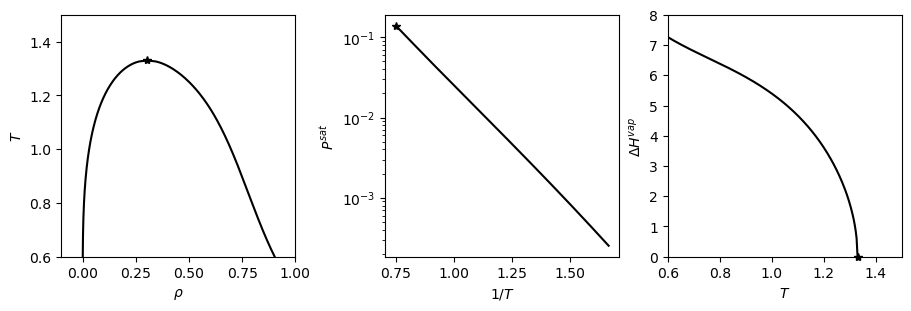

In [6]:
fig = plt.figure(figsize=(9, 3), constrained_layout=True)
ax1 = fig.add_subplot(131)
ax1.plot(rhov, T, color='k')
ax1.plot(rhol, T, color='k')
ax1.plot(rhoc_model, Tc_model, '*',color='k')
ax1.set_xlim([-1e-1, 1.0])
ax1.set_ylim([0.6, 1.5])
ax1.set_xlabel(r"$\rho$")
ax1.set_ylabel(r"$T$")

ax2 = fig.add_subplot(132)
ax2.semilogy(1./T, pressure_l, color='k')
ax2.semilogy(1./Tc_model, Pc_model, '*', color='k')
# ax1.set_xlim([-1e-1, 1.0])
# ax1.set_ylim([0.6, 1.5])
ax2.set_xlabel(r"$1/T$")
ax2.set_ylabel(r"$P^{sat}$")

ax3 = fig.add_subplot(133)
ax3.plot(T, hvap, color='k')
ax3.plot(Tc_model, [0.0], '*', color='k', clip_on=False)
ax3.set_xlim([0.6, 1.5])
ax3.set_ylim([0., 8.])
ax3.set_xlabel(r"$T$")
ax3.set_ylabel(r"$\Delta H^{vap}$")